# **Proyecto de Data Science Aplicada al Predicción de Enfermedades Cardíacas**
**Autor:** Gaggiamo, Matias Andres

*Un proyecto de análisis y modelado predictivo a partir de datos médicos públicos, con aplicaciones potenciales en sistemas de apoyo a la decisión clínica.*

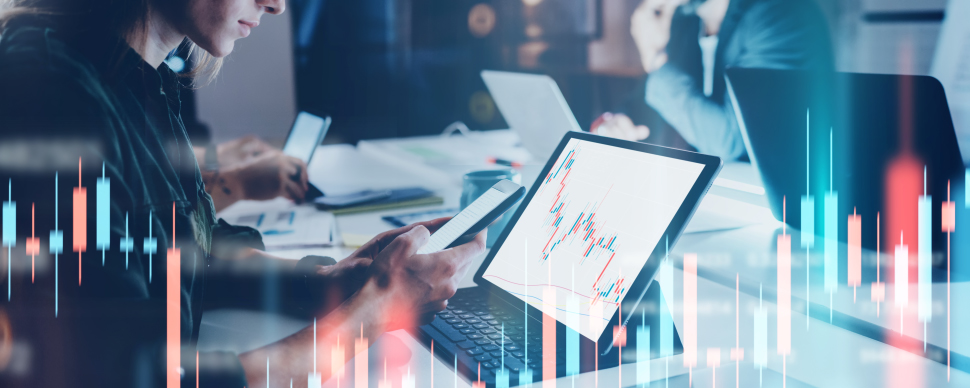

## 0. Introducción

Este trabajo final fue desarrollado como parte del curso de Data Science dictado por la Facultad Regional Buenos Aires de la Universidad Tecnológica Nacional (UTN FRBA). Como estudiante avanzado de la carrera de Bioingeniería de la Facultad de Ingeniería de la Universidad Nacional de Entre Ríos (FI-UNER), este proyecto representó una oportunidad para integrar mis conocimientos en ingeniería biomédica con herramientas de análisis de datos aplicadas a desafiós reales del ámbito de la salud.

El objetivo principal del trabajo fue analizar un conjunto de datos médicos vinculados a parámetros cardiovasculares y desarrollar un modelo de machine learning capaz de estimar la presencia o ausencia de enfermedades cardíacas. La elección del tema responde al impacto crítico de las enfermedades cardiovaculares, una de las principales causas de mortalidad a nivel mundial, y al creciente rol que tienen los datos en mejorar la toma de decisiones clínicas.

A lo largo del desarrollo, se aplicaron técnicas de preprocesamiento, análisis exploratorio de datos (EDA), selección de variables y modelado predictivo, utilizando Python y sus librerías principales en ciencia de datos. El enfoque fue orientado a la reproducibilidad, la interpretación clínica de los resultados y su aplicabilidad a entornos reales.

El presente informe presenta en detalle cada etapa del proceso, desde la definición del problema y el análisis del dataset, hasta la implementación y evaluación del modelo junto a la interpretación de los resultados. Asimismo, se proponen posibles aplicaciones del modelo en entornos clínicos y se identifican líneas futuras de trabajo. Este proyecto refleja mi interés en el cruce entre tecnología, datos y salud, y constituye un primer paso hacia mi desarrollo profesional en el área de salud digital.

## 1. Inicio: Carga y Contexto del dataset

### 1.1 Carga del data set



El dataset utilizado en este proyecto proviene del repositorio público "UCI Machine Learning Repository", y corresponde al dataset "Statlog (Heart) Dataset". Este incluye mediciones clínicas de pacientes, con el objetivo de predecir la presencia o ausencia de una enfermedad cardíaca.

*Aclaración: el archivo descargado se encontraba en formato ".dat", por lo que se realizó una conversión a ".csv" para facilitar su análisis en Python*

In [268]:
# Importación de librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Monta Google Drive en el entorno de Colab
# from google.colab import drive
# drive.mount('/content/drive')

from pathlib import Path
import os, warnings

warnings.filterwarnings("ignore")
sns.set_theme(context="notebook", style="whitegrid")

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / ".git").exists() or (p / "data").exists():
            return p
    return start
PROJECT_ROOT = find_project_root(Path.cwd())
os.chdir(PROJECT_ROOT)
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

print("Working dir: ", PROJECT_ROOT)
print("DATA_DIR   :", DATA_DIR)

Working dir:  c:\Users\matia\Proyectos\ml-heart-disease-prediction
DATA_DIR   : c:\Users\matia\Proyectos\ml-heart-disease-prediction\data


In [269]:
import pandas as pd, re

CSV_PATH = DATA_DIR / "heart.csv"
DAT_PATH = DATA_DIR / "heart.dat"

# Asignación de nombres a las columnas, según la documentación del dataset
COLS = ["age", "sex", "chest-pain", "rest-bp",
              "serum-chol", "fasting-blood-sugar", "ecg",
              "max-heart-rate", "angina", "oldpeak",
              "slope", "major-vessels", "thal", "heart-disease"]

def load_heart(prefer_csv= True):
    if prefer_csv and CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        print(f"Cargado CSV: {CSV_PATH.relative_to(PROJECT_ROOT)} | shape={df.shape}")
    
    if DAT_PATH.exists():
        try:
            df = pd.read_csv(DAT_PATH, sep=r"\s+|,", engine="python", header=None)
        except Exception:
            rows = []
            with open(DAT_PATH, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    parts = re.split(r"\s+", line.strip())
                    rows.append(parts)
                df = pd.DataFrame(rows)
        
        df = df.iloc[:, :14]
        df.columns = COLS
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="ignore")

        df.to_csv(CSV_PATH, index = False)
        print(f"Cargado DAT y generado CSV: {CSV_PATH.relative_to(PROJECT_ROOT)}  | shape={df.shape}")
        return df
    
    raise FileNotFoundError("No se encontró data/heart.csv ni data/heart.dat. Copiá uno de ellos a 'data/'.")
    
df = load_heart(prefer_csv = True)
df.head()

Cargado CSV: data\heart.csv | shape=(270, 14)
Cargado DAT y generado CSV: data\heart.csv  | shape=(270, 14)


,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,ecg,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,heart-disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


⚠️ Si estás ejecutando este notebook en Google Colab, asegurate de montar Google Drive para acceder al archivo con:
```python
from google.colab import drive
drive.mount('/content/drive')

### 1.2 Diccionario de variables

| Nº | **Variable**             | **Descripción**                                                                 | **Tipo**       | **Valores posibles**                            |
|----|--------------------------|---------------------------------------------------------------------------------|----------------|--------------------------------------------------|
| 1  | `age`                    | Edad del paciente                                                               | Continua       | Años (número real)                              |
| 2  | `sex`                    | Sexo del paciente                                                               | Binaria        | 1 = Hombre, 0 = Mujer                           |
| 3  | `chest-pain`             | Tipo de dolor de pecho                                                          | Categórica     | 1 = Angina típica, 2 = Atípica, 3 = No angina, 4 = Asintomático |
| 4  | `rest-bp`                | Presión arterial en reposo                                                      | Continua       | mmHg (número real)                              |
| 5  | `serum-chol`             | Nivel de colesterol en sangre                                                   | Continua       | mg/dl (número real)                             |
| 6  | `fasting_blood_sugar`    | Azúcar en sangre en ayunas > 120 mg/dl                                          | Binaria        | 1 = Verdadero, 0 = Falso                        |
| 7  | `ecg`                    | Resultados del electrocardiograma en reposo                                     | Categórica     | 0 = Normal, 1 = Anomalía ST/T, 2 = Hipertrofia ventricular (criterio de Estes) |
| 8  | `max-heart-rate`         | Máxima frecuencia cardíaca alcanzada durante el ejercicio                       | Continua       | Latidos por minuto (número real)               |
| 9  | `angina`                 | Presencia de angina inducida por el ejercicio                                   | Binaria        | 1 = Sí, 0 = No                                  |
| 10 | `oldpeak`                | Depresión del segmento ST respecto al estado de reposo                          | Continua       | mV (número real)                                |
| 11 | `slope`                  | Pendiente del segmento ST en esfuerzo máximo                                    | Categórica     | 1 = Ascendente, 2 = Plana, 3 = Descendente      |
| 12 | `major_vessels`          | Número de vasos principales coloreados mediante fluoroscopía                    | Categórica     | 0, 1, 2, 3                                      |
| 13 | `thal`                   | Tipo de defecto detectado en estudio de talio                                   | Categórica     | 3 = Normal, 6 = Defecto fijo, 7 = Defecto reversible |
| 14 | `heart_disease`          | Diagnóstico de enfermedad cardíaca (variable objetivo)                          | Categórica     | 1 = Ausencia, 2 = Presencia                     |

### 1.3 Contexto del tópico elegido

Como estudiante de Bioingeniería con interés en el análisis de datos biomédicos, he decidido centrar este proyecto en la detección temprana y predicción de enfermedades cardíacas. Se trata de un problema de gran relevancia sanitaria, ya que las enfermedes cardiovasculares representan una de las principales causas de morbilidad y mortalidad a nivel global.

El propósito de este trabajo es aplicar las tecnologías de la información y herramientas propias de la ciencia de datos para analizar grandes volúmenes de datos clínicos, con el objetivo de identificar patrones significativos y construir modelos predictivos. Estos modelos podrína contribuir a mejorar la capacidad diagnóstica del sistema de salud, facilitando la detección temprana de estas patologías y promoviendo una atención médica más eficiente y personalizada.

Este proyecto se alinea con mi objetivo a largo plazo de integrar la bioingeniería con el analísis de datos para abordar problemas reales en el ámbito de la salud. Aspiro a desarrollar soluciones innovadoras que respalden la toma de decisiones clínicas y optimicen la gestión de recursos médicos.

🎯**Objetivos**:
- Describir y analizar la relación entre variables médicas y la presencia de enfermedades cardíacas.
- Desarrollar un modelo predictivo capaz de clasificar a los pacientes como "enfermos" o "no enfermos" a partir de parámetros médicos.
- Identificar los factores con mayor peso en la predicción, como tipo de dolor en el pecho, la depresión del segmento ST, o el número de vasos principales coloreados por fluoroscopía.

## 2. Exploración y Visualización (EDA)

### 2.1 Exploración inicial

Para tener un primer vistazo del conjunto de datos, se utilizan algunos comandos fundamentales de Pandas:


In [270]:
df.head()

,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,ecg,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,heart-disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [271]:
df.shape

(270, 14)

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  270 non-null    float64
 1   sex                  270 non-null    float64
 2   chest-pain           270 non-null    float64
 3   rest-bp              270 non-null    float64
 4   serum-chol           270 non-null    float64
 5   fasting-blood-sugar  270 non-null    float64
 6   ecg                  270 non-null    float64
 7   max-heart-rate       270 non-null    float64
 8   angina               270 non-null    float64
 9   oldpeak              270 non-null    float64
 10  slope                270 non-null    float64
 11  major-vessels        270 non-null    float64
 12  thal                 270 non-null    float64
 13  heart-disease        270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


In [273]:
df.columns

Index(['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol',
       'fasting-blood-sugar', 'ecg', 'max-heart-rate', 'angina', 'oldpeak',
       'slope', 'major-vessels', 'thal', 'heart-disease'],
      dtype='object')

Estos permiten visualizar las primeras filas del dataset, conocer su dimensión, estructura y los nombres de las columnas.

Este dataset, proveniente del repositorio Uci Machine Learning Repository, es particularmente relevante para el análisis de enfermedades cardíacas, ya que contiene variables clínicas clave asociadas a factores de riesgo cardiovascular. Su tamaño (**270 registros distribuidos en 14 variables**) lo convierte en un conjunto de datos manejable para exploración y modelado, pero lo suficientemente complejo para poner en práctica técnicas de análisis de datos y machine learning.




### 2.2 Exploración estadística de variables numéricas

En esta sección se analizan las principales variables númericas del dataset. Se parte de una exploración básica para conocer medida de tendencia central y dispersión, y se continua con un análisis visual utilizando histogramas y boxplots, ademas del cálculo de outliers mediante el rango intercuartílico (IQR).

In [274]:
df.describe()

,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,ecg,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,heart-disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


**Descripción de las variables estadísticas principales para los parámetros reales o continuos**:

- **1. Edad**: promedio de 53.4 años (±9.1), con un rango de 29 a 77 años. con una desviación estándar de 9.1 años aproximadamente.
- **4. Presión arterial en reposo**: media de 131.3 mmHg (±17.9), entre 94 y 200 mmHg.
- **5. Nivel de colesterol en sangre**: promedio de 249.7 mg/dL (±51.7), con valores entre 126 y 564 mg/dL.
- **8. Máxima frecuencia cardíaca**: 149.7 lat/min (±23.2), entre 71 y 202 lat/min.
- **10. Depresión del segmento ST del ECG (Oldpeak)**: media de 1.05 mV (±1.15), con valores entre 0 y 6.2 mV.

#### 2.2.1 Edad

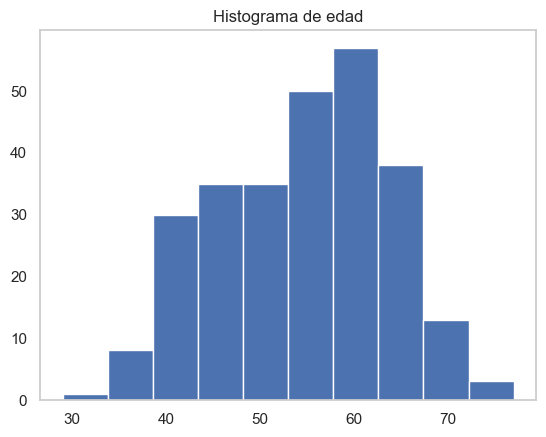

In [275]:
df[["age"]].hist(bins=10, grid=False)
plt.title("Histograma de edad")
plt.show()

Se puede notar que la edad de la muestra sigue una distribución normal, con histograma en forma de campana de Gauss.

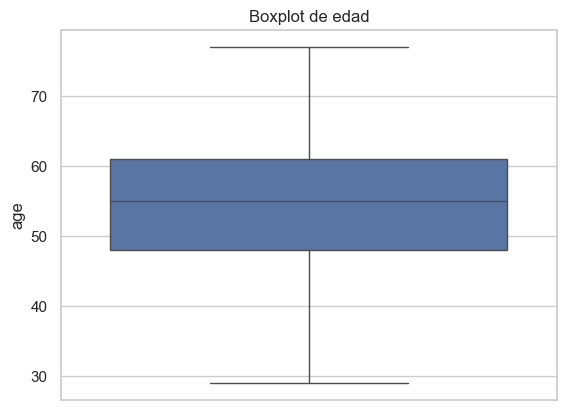

In [276]:
sns.boxplot(data = df["age"])
plt.title("Boxplot de edad")
plt.show()

In [277]:
q1 = df["age"].quantile(0.25)
q3 = df["age"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]

outlier_info = outliers[["age"]].reset_index()
print(outlier_info)

Empty DataFrame
Columns: [index, age]
Index: []


La edad presenta una distribución aproximadamente normal y no presenta valores outliers.

#### 2.2.2 Presión arterial en reposo

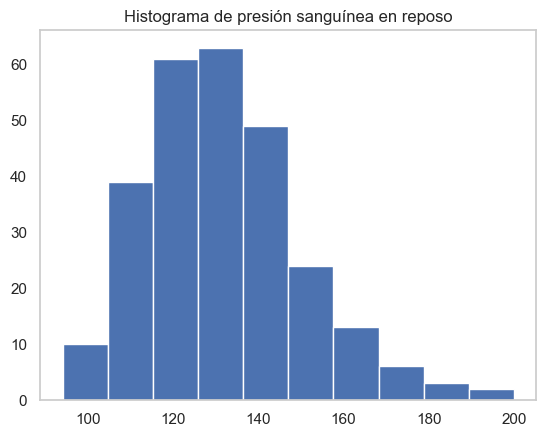

In [278]:
df[["rest-bp"]].hist(bins=10, grid=False)
plt.title("Histograma de presión sanguínea en reposo")
plt.show()

Como primera observación, podemos notar que la presión sanguínea en reposo sigue una distribución normal pero levemente sesgada hacia la derecha o positivamente.

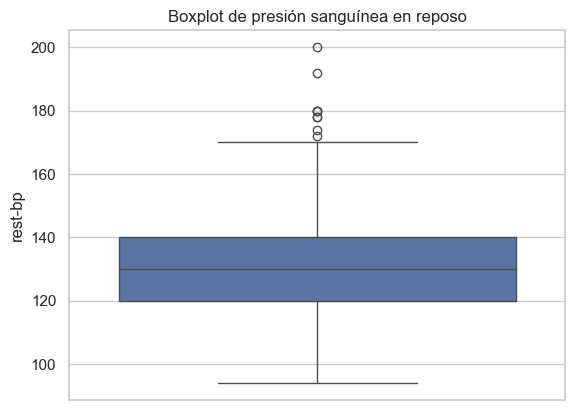

In [279]:
sns.boxplot(data = df["rest-bp"])
plt.title("Boxplot de presión sanguínea en reposo")

plt.show()

In [280]:
q1 = df["rest-bp"].quantile(0.25)
q3 = df["rest-bp"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["rest-bp"] < lower_bound) | (df["rest-bp"] > upper_bound)]

outlier_info = outliers[["rest-bp"]].reset_index()
print(outlier_info)

   index  rest-bp
0     58    174.0
1     87    178.0
2    110    180.0
3    117    200.0
4    144    192.0
5    159    178.0
6    165    180.0
7    240    180.0
8    265    172.0


Gracias a la visualización del boxplot y la definición del rango intercuartil, podemos encontrar 9 valores outliers para la presión sanguínea en reposo.

#### 2.2.3 Nivel de colesterol en sangre

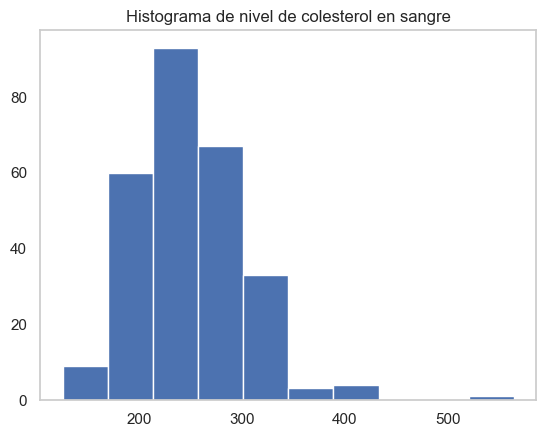

In [281]:
df[["serum-chol"]].hist(bins=10, grid=False)
plt.title("Histograma de nivel de colesterol en sangre")
plt.show()

Se puede notar una distribución normal levemente sesgada a la derecha o positivamente.

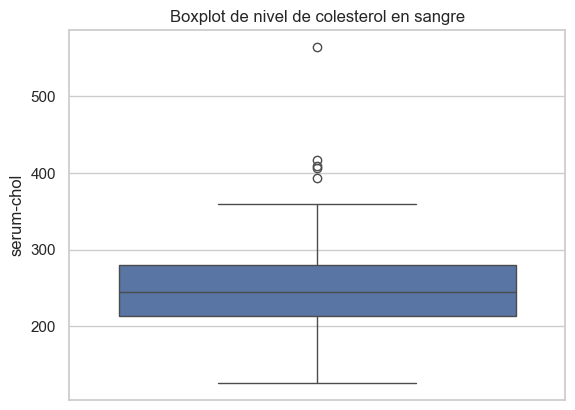

In [282]:
sns.boxplot(data = df["serum-chol"])
plt.title("Boxplot de nivel de colesterol en sangre")
plt.show()

In [283]:
q1 = df["serum-chol"].quantile(0.25)
q3 = df["serum-chol"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["serum-chol"] < lower_bound) | (df["serum-chol"] > upper_bound)]

outlier_info = outliers[["serum-chol"]].reset_index()
print(outlier_info)

   index  serum-chol
0      1       564.0
1      9       407.0
2     52       417.0
3    181       409.0
4    188       394.0


Se encuentran 5 valores outliers gracias al uso del gráfico boxplot y la definición del rango intercuartílico.

#### 2.2.4 Máximo ritmo cardíaco

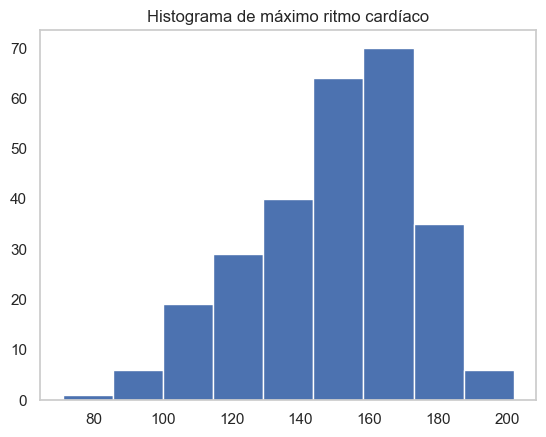

In [284]:
df[["max-heart-rate"]].hist(bins=9, grid=False)
plt.title("Histograma de máximo ritmo cardíaco")
plt.show()

Se puede observar una distribución normal de datos para el máximo ritmo cardíaco con un leve sesgo hacia la izquierda o negativo.

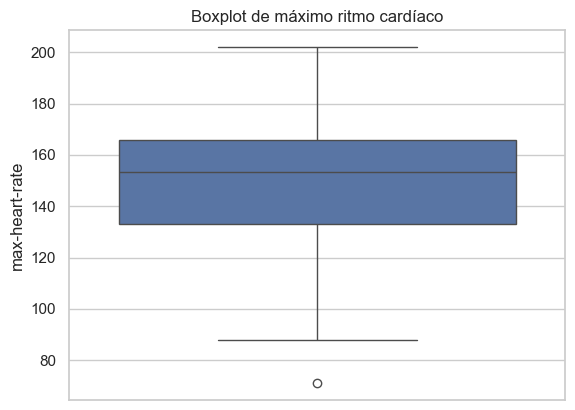

In [285]:
sns.boxplot(data = df["max-heart-rate"])
plt.title("Boxplot de máximo ritmo cardíaco")
plt.show()

In [286]:
q1 = df["max-heart-rate"].quantile(0.25)
q3 = df["max-heart-rate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["max-heart-rate"] < lower_bound) | (df["max-heart-rate"] > upper_bound)]

outlier_info = outliers[["max-heart-rate"]].reset_index()
print(outlier_info)

   index  max-heart-rate
0    101            71.0


Se encuentra un único valor outlier para el máximo ritmo cardíaco.

#### 2.2.5 Depresión del intervalo ST del ECG

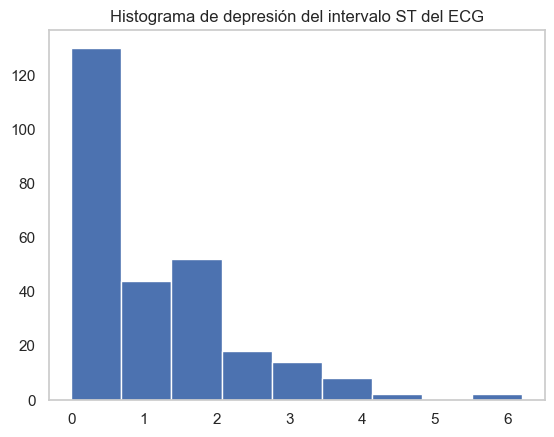

In [287]:
df[["oldpeak"]].hist(bins=9, grid=False)
plt.title("Histograma de depresión del intervalo ST del ECG")
plt.show()

Se puede observar una distribución altamente sesgada a la derecha (tipo exponencial) de los datos para el caso de la depresión del segmento ST del electrocardiagrama.

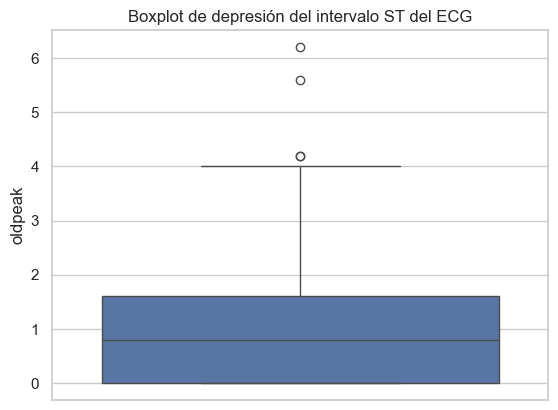

In [288]:
sns.boxplot(data = df["oldpeak"])

plt.title("Boxplot de depresión del intervalo ST del ECG")

plt.show()

In [289]:
q1 = df["oldpeak"].quantile(0.25)
q3 = df["oldpeak"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["oldpeak"] < lower_bound) | (df["oldpeak"] > upper_bound)]

outlier_info = outliers[["oldpeak"]].reset_index()
print(outlier_info)

   index  oldpeak
0     87      4.2
1    156      5.6
2    176      4.2
3    235      6.2


Se pudieron identificar 4 valores outliers para el caso de "oldpeak".

#### 2.2.6 Relación entre variables numéricas

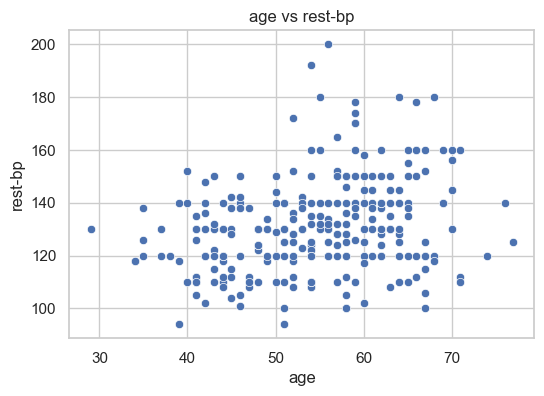

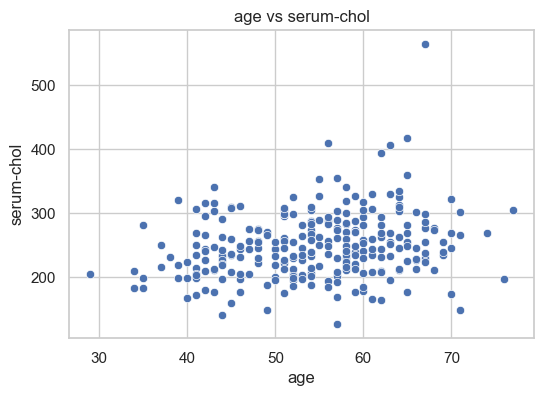

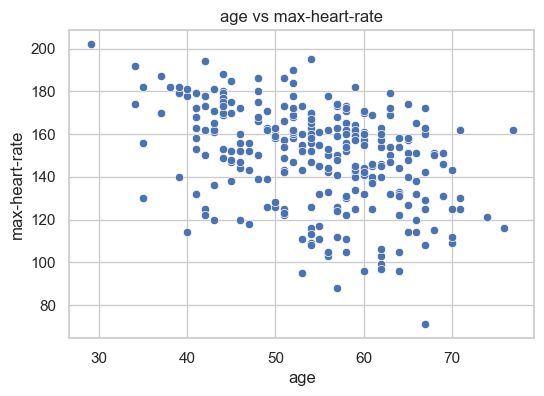

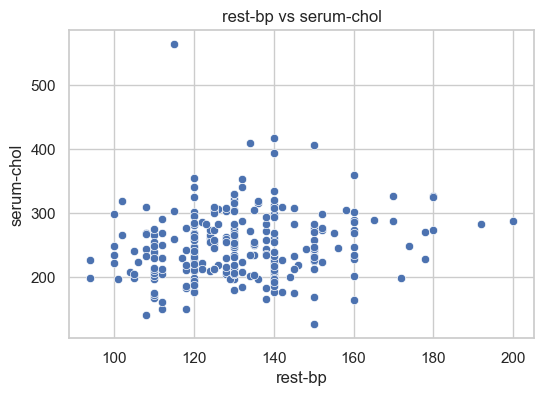

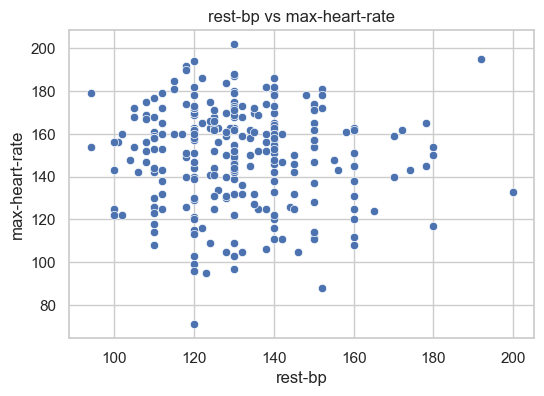

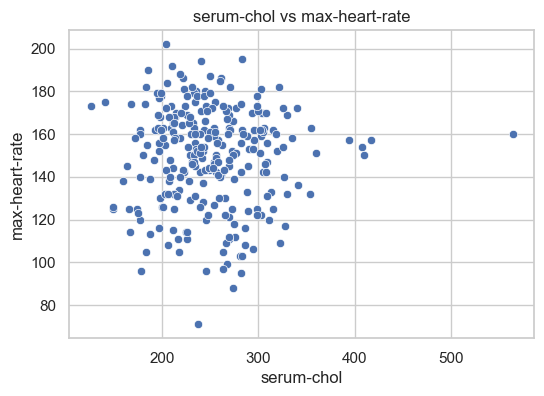

In [290]:
variables = ['age', 'rest-bp', 'serum-chol', 'max-heart-rate']

# Crear scatter plots entre cada par de variables
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=variables[i], y=variables[j], data=df)
        plt.title(f'{variables[i]} vs {variables[j]}')
        plt.xlabel(variables[i])
        plt.ylabel(variables[j])
        plt.show()

Los gráficos de dispersión no muestran relaciones lineales fuertes entre las variables numéricas, lo que sugiere que su influencia sobre la variable objetivo puede ser más compleja o depender de variables no incluidas en este conjunto. No obstante, confirmaron visualmente algunos valores atípicos previamente detectadosm como niveles de colesterol sérico y presión arterial.

La dispersión amplia observada refuerza la idea de que estas variables no tienen una dependencia directa significativa, lo que indica la necesidad de análisis más avanzados para comprender mejor su impacto en la variable objetivo.


### 2.3 Exploración estadística de variables categóricas


En esta sección se analizan las variables categóricas presentes en el conjunto de datos. Se realiza una descripción de su distribución y se discute su posible relación con la variable objetivo (heart_disease).

#### 2.3.1 Sexo

In [291]:
df['sex'].unique()

array([1., 0.])

In [292]:
df["sex"] = df["sex"].map({0.: 'Mujer', 1.: 'Hombre'})
df["sex"].value_counts()

sex
Hombre    183
Mujer      87
Name: count, dtype: int64

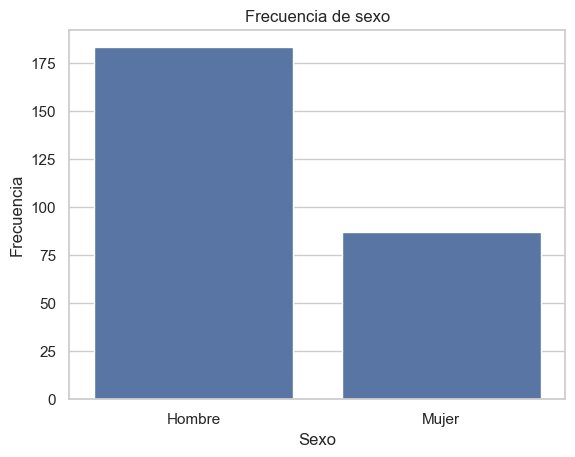

In [293]:
sns.countplot(x='sex', data=df)
plt.title(f'Frecuencia de sexo')
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')
plt.show()

La muestra está compuesta por 183 hombres (67.7%) y 87 mujeres (32.3%), mostrando un predominio de sexo masculino.

In [294]:
df['sex'].unique()

array(['Hombre', 'Mujer'], dtype=object)

In [295]:
# Revertir 'sex'
df['sex'] = df['sex'].map({'Hombre': 1., 'Mujer': 0.})
df['sex'].unique()

array([1., 0.])

In [296]:
df['sex'].value_counts()

sex
1.0    183
0.0     87
Name: count, dtype: int64

#### 2.3.2 Tipo de dolor de pecho

In [297]:
df["chest-pain"].unique()

array([4., 3., 2., 1.])

In [298]:
df['chest-pain'] = df['chest-pain'].map({
    1.: 'Angina típica',
    2.: 'Angina atípica',
    3.: 'No angina',
    4.: 'Asintomático'
})

df["chest-pain"].value_counts()

chest-pain
Asintomático      129
No angina          79
Angina atípica     42
Angina típica      20
Name: count, dtype: int64

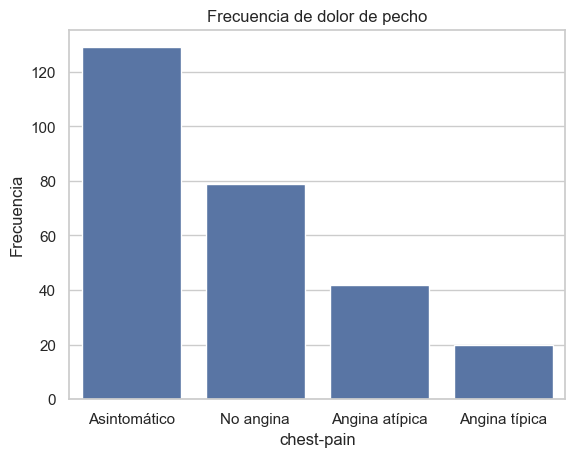

In [299]:
sns.countplot(x='chest-pain', data=df, order=df['chest-pain'].value_counts().index)
plt.title(f'Frecuencia de dolor de pecho')
plt.xlabel('chest-pain')
plt.ylabel('Frecuencia')
plt.show()

Se puede observar que en la muestra, 129 personas son asintomáticas, 79 presentan dolor no correspondiente a angina, 42 presentan un dolor tipo angina atípica y 20 un dolor tipo angina típica.

In [300]:
# Revertir 'chest-pain'
df['chest-pain'] = df['chest-pain'].replace({
    'angina típica': 1.,
    'angina atípica': 2.,
    'dolor no angina': 3.,
    'asintomático': 4.
})

#### 2.3.3 Nivel de azúcar en sangre en ayuno

In [301]:
df["fasting-blood-sugar"].value_counts()

fasting-blood-sugar
0.0    230
1.0     40
Name: count, dtype: int64

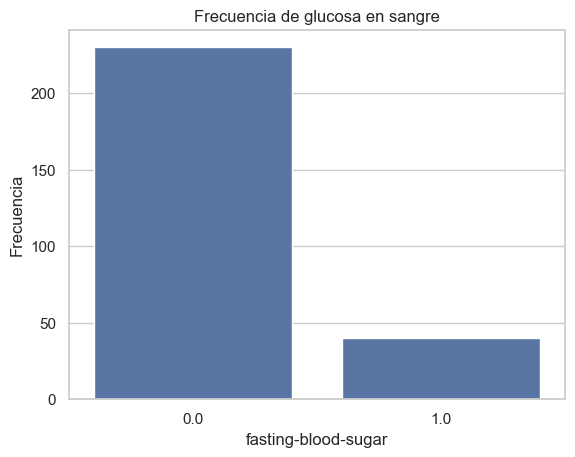

In [302]:
sns.countplot(x='fasting-blood-sugar', data=df)
plt.title(f'Frecuencia de glucosa en sangre')
plt.xlabel('fasting-blood-sugar')
plt.ylabel('Frecuencia')
plt.show()

Se puede observar que de la muestra, 230 personas (85.2%) presentan un nivel de azúcar en sangre menor a 120 mg/dl y solo 40 personas (14.8%) un nivel mayor a esa medida.

In [303]:
df['fasting-blood-sugar'].unique()

array([0., 1.])

#### 2.3.4 Resultado del electrocardiograma

In [304]:
df['ecg'].unique()

array([2., 0., 1.])

In [305]:
df['ecg'] = df['ecg'].map({
    0.: 'Normal',
    1.: 'Anormalidad ST-T',
    2.: 'Hipertrofia ventricular'
})

df["ecg"].value_counts()

ecg
Hipertrofia ventricular    137
Normal                     131
Anormalidad ST-T             2
Name: count, dtype: int64

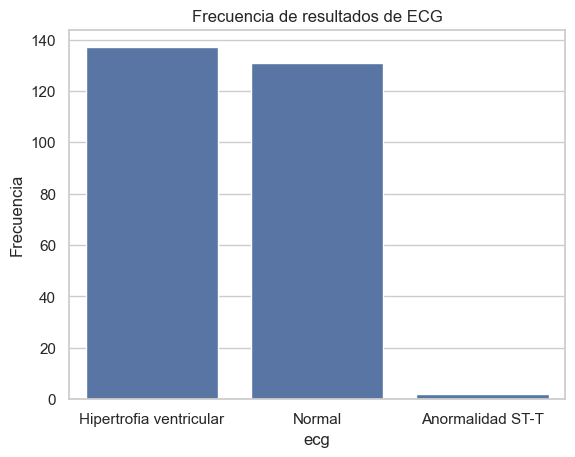

In [306]:
sns.countplot(x='ecg', data=df)
plt.title(f'Frecuencia de resultados de ECG')
plt.xlabel('ecg')
plt.ylabel('Frecuencia')
plt.show()

En la muestra, 131 personas presentan un electrocardiograma normal en reposo, 137 personas presentan una hipertrofia del ventrículo derecho según el criterio de Estes y solo 2 personas presentan un período de onda T anormal.

In [307]:
df['ecg'].unique()

array(['Hipertrofia ventricular', 'Normal', 'Anormalidad ST-T'],
      dtype=object)

In [308]:
# Revertir 'ecg'
df['ecg'] = df['ecg'].replace({
    'Normal': 0.,
    'Anormalidad ST-T': 1.,
    'Hipertrofia ventricular': 2.
})

In [309]:
df['ecg'].unique()

array([2., 0., 1.])

In [310]:
df['ecg'].value_counts()

ecg
2.0    137
0.0    131
1.0      2
Name: count, dtype: int64

#### 2.3.5 Presencia de angina durante el ejercicio

In [311]:
df["angina"].value_counts()

angina
0.0    181
1.0     89
Name: count, dtype: int64

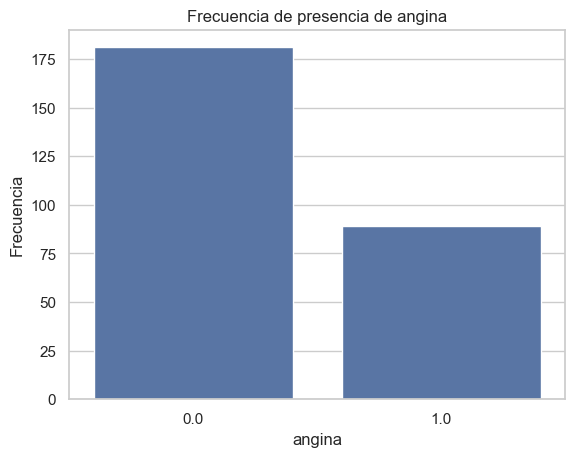

In [312]:
sns.countplot(x='angina', data=df)
plt.title(f'Frecuencia de presencia de angina')
plt.xlabel('angina')
plt.ylabel('Frecuencia')
plt.show()

Se observa que el 67.0% de las personas no presenta angina durante el ejercicio, mientras que el 33.0% sí la experimenta.

#### 2.3.6 Pendiente del intervalo ST del ECG

In [313]:
df["slope"].unique()

array([2., 1., 3.])

In [314]:
df['slope'] = df['slope'].map({
    1.: 'Ascendente',
    2.: 'Plana',
    3.: 'Descendente'
})

df["slope"].value_counts()

slope
Ascendente     130
Plana          122
Descendente     18
Name: count, dtype: int64

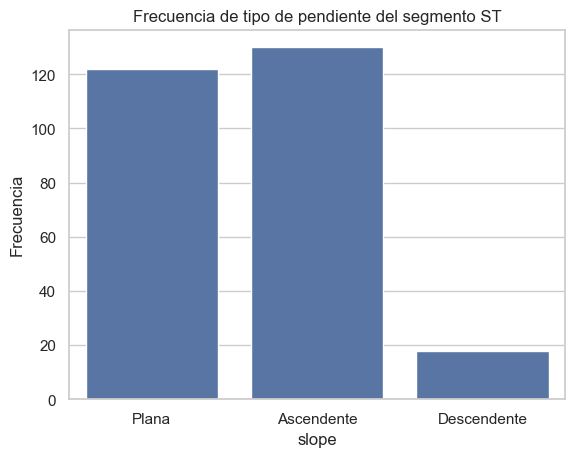

In [315]:
sns.countplot(x='slope', data=df)
plt.title(f'Frecuencia de tipo de pendiente del segmento ST')
plt.xlabel('slope')
plt.ylabel('Frecuencia')
plt.show()

Se puede observar que 130 personas presentan una pendiente del segmento ST del electrocardiograma ascendente, 122 una pendiente plana y 18 personas una pendiente descendente.

In [316]:
df['slope'].unique()

array(['Plana', 'Ascendente', 'Descendente'], dtype=object)

In [317]:
# Revertir 'slope'
df['slope'] = df['slope'].replace({
    'Ascendente': 1.,
    'Plana': 2.,
    'Descendente': 3.
})

In [318]:
df['slope'].unique()

array([2., 1., 3.])

In [319]:
df['slope'].value_counts()

slope
1.0    130
2.0    122
3.0     18
Name: count, dtype: int64

#### 2.3.7 Número de arterias principales

In [320]:
df["major-vessels"].value_counts()

major-vessels
0.0    160
1.0     58
2.0     33
3.0     19
Name: count, dtype: int64

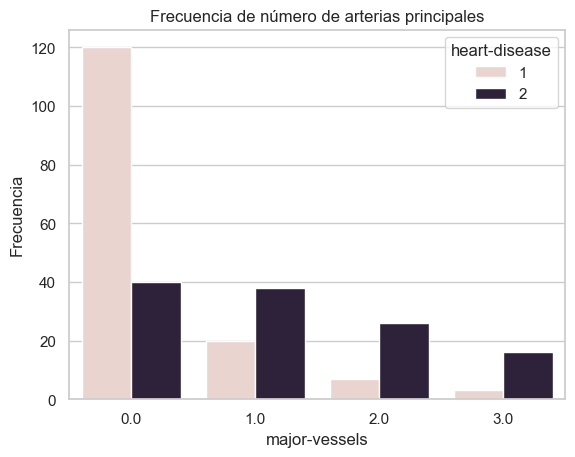

In [321]:
sns.countplot(x='major-vessels', data=df, hue='heart-disease')
plt.title(f'Frecuencia de número de arterias principales')
plt.xlabel('major-vessels')
plt.ylabel('Frecuencia')
plt.show()

De los datos, se sabe que 160 personas no presentan vasos principales coloreados por fluroscopia, 58 un vaso, 33 dos vasos y 19 tres vasos sanguíneos.

La variable major-vessels, que indica el número de vasos sanguíneos principales coloreados por fluoroscopia (valores posibles: 0, 1, 2 o 3), muestra una distribución marcadamente diferente según la presencia o no de enfermedad cardíaca.

Al analizar su frecuencia para cada clase de la variable objetivo heart-disease, se observa que:

- La mayoría de los pacientes sin enfermedad cardíaca (clase 1) tienen 0 arterias coloreadas.

- En cambio, los pacientes con enfermedad cardíaca (clase 2) tienden a tener un mayor número de vasos coloreados (1, 2 o incluso 3).

- Existe una tendencia creciente en la frecuencia de enfermedad a medida que aumenta el número de vasos detectados, lo cual sugiere una correlación positiva entre major-vessels y la presencia de enfermedad cardíaca.

Esta variable podría tener un alto poder predictivo al ser incluida en un modelo de clasificación, ya que presenta un comportamiento distintivo entre las clases. Su análisis refuerza la idea de que la obstrucción o alteración en múltiples vasos coronarios puede estar asociada a una mayor probabilidad de padecer enfermedad cardíaca.

#### 2.3.8 Presencia de defecto cardíaco

In [322]:
df['thal'] = df['thal'].map({
    3: 'Normal',
    6: 'Defecto fijo',
    7: 'Defecto reversible'
})

df["thal"].value_counts()

thal
Normal                152
Defecto reversible    104
Defecto fijo           14
Name: count, dtype: int64

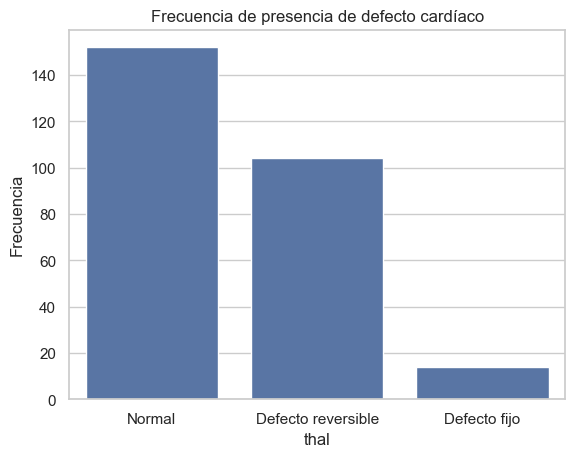

In [323]:
sns.countplot(x='thal', data=df)
plt.title(f'Frecuencia de presencia de defecto cardíaco')
plt.xlabel('thal')
plt.ylabel('Frecuencia')
plt.show()

152 personas no presentan ningun defecto, 14 personas presentan un defecto fijo y 104 personas un defecto reversible.

In [324]:
df['thal'].unique()

array(['Normal', 'Defecto reversible', 'Defecto fijo'], dtype=object)

In [325]:
# Revertir 'thal'
df['thal'] = df['thal'].replace({
    'Normal': 3.,
    'Defecto fijo': 6.,
    'Defecto reversible': 7.
})

In [326]:
df['thal'].unique()

array([3., 7., 6.])

In [327]:
df['thal'].value_counts()

thal
3.0    152
7.0    104
6.0     14
Name: count, dtype: int64

#### 2.3.9 Matriz de correlación

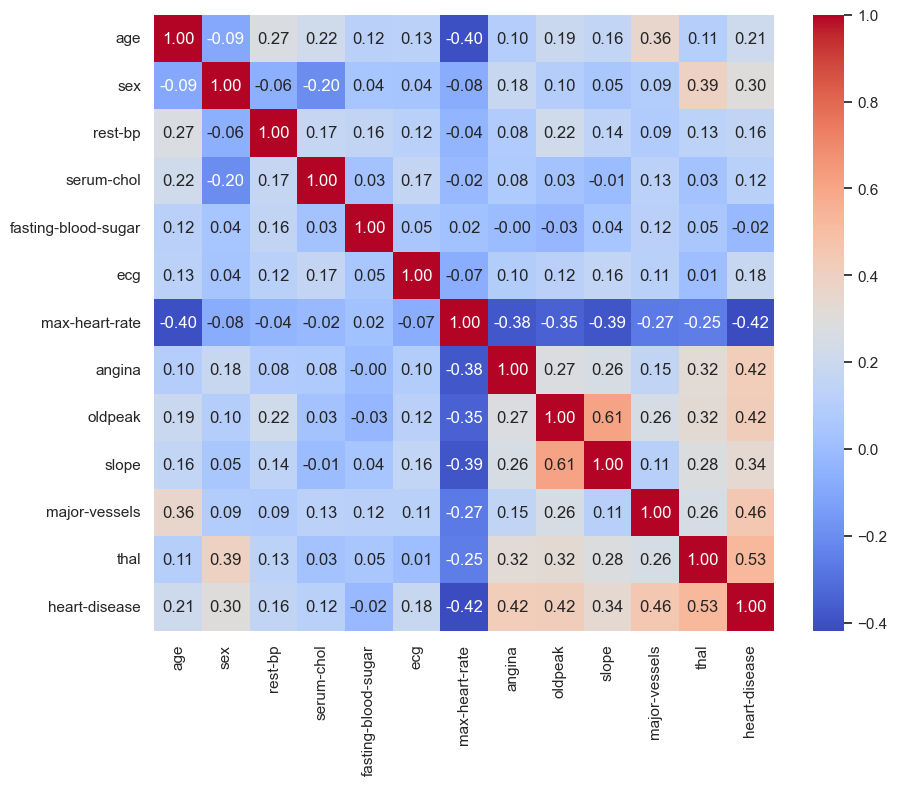

In [328]:
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Se observa una correlación negativa moderada entre la frecuencia cardíaca máxima y la presencia de enfermedad cardíaca (r = -0.42), y correlaciones positivas con variables como tipo de dolor de pecho, presencia de angina, pendiente ST, número de vasos principales y defecto cardíaco, todas mayores a 0.4.

In [329]:
df["heart-disease"].value_counts()

heart-disease
1    150
2    120
Name: count, dtype: int64

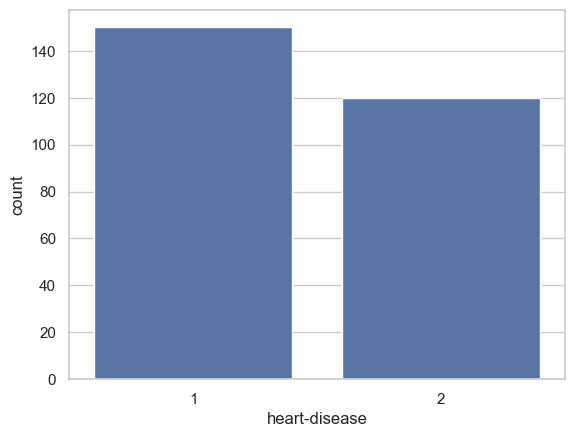

In [330]:
sns.countplot(x='heart-disease', data=df)
plt.show()

150 personas no padecen de una enfermedad cardíaca y 120 si padecen.

## 3. Limpieza de Datos

### 3.1 Verificación valores nulos

In [331]:
# Verificar la cantidad de valores nulos por columna
df.isnull().sum()

age                    0
sex                    0
chest-pain             0
rest-bp                0
serum-chol             0
fasting-blood-sugar    0
ecg                    0
max-heart-rate         0
angina                 0
oldpeak                0
slope                  0
major-vessels          0
thal                   0
heart-disease          0
dtype: int64

No se presentan valores nulos en ninguna columna del conjunto de datos, por lo que no es necesario aplicar imputación ni eliminación de filas/columnas.

### 3.2 Verificación duplicados

In [332]:
# Verificar duplicados
df.duplicated().sum()

np.int64(0)

No se detectan registros duplicados, por lo tanto no se requiere ninguna acción adicional en este paso.

### 3.3 Análisis de valores outliers en variables numéricas

Durante la etapa exploratoria se analizaron los valores atípicos mediante diagramas de caja (boxplots) y métodos basados en el rango intercuartílico (IQR). A continuación, se detalla el tratamiento adoptado para cada variable numérica:

**Edad** (age)
No se identificaron valores atípicos. Los valores se encuentran dentro del rango clínicamente esperable.

→ No se realiza ninguna acción.


**Presión arterial en reposo** (rest-bp) Se encontraron 9 valores por fuera del rango. Decidí mantener los valores extremos en el dataset, ya que representan casos clínicamente posibles. Aunque estos valores son altos y se identificaron como outliers, pueden ser indicadores relevantes para el modelo, especialmente porque la hipertensión severa es un factor de riesgo significativo en la aparición de enfermedades cardíacas. Eliminarlos podría llevar a una pérdida de información importante que podría afectar la capacidad del modelo para identificar patrones relacionados con la enfermedad cardíaca en pacientes con valores extremos. Por lo tanto, opté por incluirlos inicialmente para evaluar cómo contribuyen al rendimiento del modelo de clasificación. Sin embargo, si en etapas posteriores del desarrollo del modelo se observa que estos valores afectan negativamente su rendimiento o introducen ruido que compromete la fiabilidad de las predicciones, consideraré estrategias para manejarlos. Esto podría incluir su eliminación o intercambio con valores más representativos del rango observado.

→ No se realiza ninguna acción.


**Colesterol en sangre** (serum-chol) Los valores extremos listados aquí, aunque elevados, representan valores posibles en pacientes con hipercolesterolemia severa. En el contexto de la predicción de enfermedades cardíacas, estos valores pueden ser particularmente relevantes, ya que el colesterol elevado es un factor de riesgo para problemas cardiovasculares. Por lo tanto, inicialmente optaría por mantener estos valores en el dataset para no perder información valiosa que pueda mejorar la capacidad del modelo de identificar patrones asociados a la enfermedad. Sin embargo, igual que en el caso de la presión arterial, monitorearía su impacto en el rendimiento del modelo. Si se detecta que estos valores extremos introducen ruido o dificultan el aprendizaje del modelo, consideraría aplicar técnicas como normalización, o incluso eliminarlos si es necesario.

→ No se realiza ninguna acción.


**Frecuencia cardíaca máxima** (max-heart-rate) El valor outlier de 71 lat/min claramente no se ajusta a lo esperado en este tipo de análisis, ya que está muy por debajo del rango típico observado en pruebas de esfuerzo o actividad física, donde los valores suelen superar ampliamente los 100 lat/min. Este dato podría ser un error de registro o representar un caso muy aislado que no aporta información útil al modelo. Además, mantenerlo podría sesgar el análisis y afectar las predicciones, ya que el modelo podría interpretarlo como un caso representativo cuando no lo es.
Por este motivo, decidí eliminarlo del dataset.

→ Se decide eliminar este valor para evitar sesgos en el modelo.

In [333]:
Q1 = df["max-heart-rate"].quantile(0.25)
Q3 = df["max-heart-rate"].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['max-heart-rate'] < (Q1 - 1.5 * IQR)) | (df['max-heart-rate'] > (Q3 + 1.5 * IQR)))]

In [334]:
q1 = df["max-heart-rate"].quantile(0.25)
q3 = df["max-heart-rate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["max-heart-rate"] < lower_bound) | (df["max-heart-rate"] > upper_bound)]

outlier_info = outliers[["max-heart-rate"]].reset_index()
print(outlier_info)

Empty DataFrame
Columns: [index, max-heart-rate]
Index: []


Verificación de la eliminación del valor atípico.

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 0 to 269
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  269 non-null    float64
 1   sex                  269 non-null    float64
 2   chest-pain           269 non-null    object 
 3   rest-bp              269 non-null    float64
 4   serum-chol           269 non-null    float64
 5   fasting-blood-sugar  269 non-null    float64
 6   ecg                  269 non-null    float64
 7   max-heart-rate       269 non-null    float64
 8   angina               269 non-null    float64
 9   oldpeak              269 non-null    float64
 10  slope                269 non-null    float64
 11  major-vessels        269 non-null    float64
 12  thal                 269 non-null    float64
 13  heart-disease        269 non-null    int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 31.5+ KB


Se chequea que el valor outlier ha sido eliminado correctamente.

**Depresión del segmento ST** (oldpeak) Se decide explorar primero si estos valores se relacionan directamente con que la persona padezca una enfermedad cardíaca.

In [336]:
q1 = df["oldpeak"].quantile(0.25)
q3 = df["oldpeak"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["oldpeak"] < lower_bound) | (df["oldpeak"] > upper_bound)]

outliers_heart_disease = outliers[['oldpeak', 'heart-disease']]

print(outliers_heart_disease)

     oldpeak  heart-disease
87       4.2              1
156      5.6              2
176      4.2              2
235      6.2              2


En el caso de los valores atípicos en la variable oldpeak, se observa que algunos de estos valores están asociados con la presencia de enfermedad cardíaca (heart_disease = 2), como el caso del valor 5.6, lo que sugiere que estos valores podrían ser representaciones de situaciones clínicas reales. La depresión del segmento ST, es una característica importante en el diagnóstico de la enfermedad cardíaca, por lo que estos valores elevados pueden aportar información relevante para la predicción de la enfermedad. Dado que los outliers en oldpeak están vinculados a la presencia de la enfermedad, no se eliminan de inmediato, ya que su eliminación podría llevar a la pérdida de datos valiosos. Se mantendrán en el modelo, pero se continuará monitoreando el impacto que puedan tener en el rendimiento del modelo.

→ Se opta por conservar estos valores y monitorear su impacto en el modelo.

### 3.4 Conversión de columnas a numéricas o categóricas

Para asegurar un correcto procesamiento posterior, se ajustan los tipos de datos. Las variables continuas se convierten a numéricas, y las variables discretas o categóricas se transforman a tipo category.

In [337]:
# Conversión a numéricas
df['age'] = pd.to_numeric(df['age'])
df['rest-bp'] = pd.to_numeric(df['rest-bp'])
df['serum-chol'] = pd.to_numeric(df['serum-chol'])
df['max-heart-rate'] = pd.to_numeric(df['max-heart-rate'])
df['oldpeak'] = pd.to_numeric(df['oldpeak'])

In [338]:
# Conversión a categóricas
categorical_cols = ['sex', 'chest-pain', 'fasting-blood-sugar', 'ecg',
                    'angina', 'slope', 'major-vessels', 'thal', 'heart-disease']

for col in categorical_cols:
    df[col] = df[col].astype('category')

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 0 to 269
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  269 non-null    float64 
 1   sex                  269 non-null    category
 2   chest-pain           269 non-null    category
 3   rest-bp              269 non-null    float64 
 4   serum-chol           269 non-null    float64 
 5   fasting-blood-sugar  269 non-null    category
 6   ecg                  269 non-null    category
 7   max-heart-rate       269 non-null    float64 
 8   angina               269 non-null    category
 9   oldpeak              269 non-null    float64 
 10  slope                269 non-null    category
 11  major-vessels        269 non-null    category
 12  thal                 269 non-null    category
 13  heart-disease        269 non-null    category
dtypes: category(9), float64(5)
memory usage: 16.2 KB


In [340]:
df.head()

,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,ecg,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,heart-disease
0,70.0,1.0,Asintomático,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,No angina,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,Angina atípica,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,Asintomático,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,Angina atípica,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


## 4. Resumen de Hallazgos Iniciales

Después de realizar un análisis exploratorio y estadístico del dataset, se han identificado hallazgos relevantes que permiten comenzar a comprender la estructura de los datos y el comportamiento de las variables respecto a la presencia de enfermedad cardíaca.

### 4.1 Calidad del dataset

- El conjunto de datos original contenía 270 registros. Se eliminaron los registros con outliers extremos que pudieran ser errores o afectar negativamente al modelo (por ejemplo, un valor anómalo de max-heart-rate).

- No se encontraron valores nulos ni duplicados.

- Se verificó que las variables categóricas y numéricas estén correctamente tipificadas para su posterior uso en el modelado.

### 4.2 Variables numéricas

- **rest-bp** y **serum-chol** presentaron outliers, pero se decidió mantenerlos dado que representan posibles condiciones clínicas (hipertensión o hipercolesterolemia).

- **oldpeak** mostró valores altos relacionados con la presencia de enfermedad cardíaca (heart-disease = 2). Dado que refleja depresión del segmento ST, un indicador clínico importante, se mantendrán estos valores por su potencial valor predictivo.

- En **max-heart-rate**, se detectó un valor muy bajo (71 lat/min), que no era consistente con los valores esperados en pruebas de esfuerzo. Se optó por eliminarlo al considerarlo un caso aislado o potencial error de registro.

### 4.3 Variables categóricas

Se observaron distribuciones desbalanceadas en algunas variables, por ejemplo:

- Mayor proporción de hombres que mujeres.

- Alta frecuencia de casos asintomáticos en la variable chest-pain.

- Poca presencia de algunos valores en thal, major-vessels y ecg.

Estos desbalances podrían influir en el rendimiento de los modelos predictivos, por lo que se tendrán en cuenta durante el preprocesamiento y el entrenamiento.

### 4.4 Correlaciones

- La matriz de correlación no mostró asociaciones lineales fuertes entre las variables numéricas y la variable objetivo **heart-disease**.

- Esto sugiere que la relación entre las variables independientes y la presencia de enfermedad cardíaca podría no ser lineal, o depender de interacciones entre múltiples variables.

- Por esta razón, se decidió conservar todas las variables, incluso aquellas con baja correlación individual, para permitir que modelos más complejos (como árboles o ensambles) puedan captar relaciones no lineales.

### 4.5 Consideraciones para el modelado

- Se optó por mantener los outliers clínicamente posibles para no perder información relevante, monitoreando su impacto durante la evaluación de modelos.

- La variable objetivo (heart-disease) está levemente desbalanceada, por lo que será importante evaluar métricas como recall y f1-score, además del accuracy, al momento de modelar.

- Todas las variables fueron convertidas correctamente a su tipo de dato correspondiente (float o category), lo que facilitará su transformación posterior (e.g. codificación, escalado).

## 5. Definición del problema y justificación del modelo de Machine Learning elegido

El objetivo principal de este proyecto es desarrollar un modelo de *Machine Learning* capaz de predecir la **presencia de enfermedad cardíaca** en pacientes, utilizando información médica y fisiológica. Esta tarea se enmarca dentro del aprendizaje supervisado, específicamente como un problema de clasificación binaria, ya que la variable objetivo (*heart-disease*) indica si un paciente presenta (2) o no presenta (1) enfermedad cardíaca.

La posibilidad de predecir el riesgo de enfermedad cardíaca de forma automatizada es de gran relevancia para la medicina preventiva. Detectar de manera temprana a pacientes con alto riesgo podría permitir a los profesionales de la salud tomar decisiones más informadas, asignar recursos de manera eficiente y aplicar intervenciones clínicas oportunas.

El dataset utilizado contiene diversas variables clínicas y fisiológicas de cada paciente, tales como:

- Edad (age)

- Sexo (sex)

- Tipo de dolor de pecho (chest-pain)

- Presión arterial en reposo (rest-bp)

- Colesterol sérico (serum-chol)

- Frecuencia cardíaca máxima alcanzada (max-heart-rate)

- Resultados del electrocardiograma en reposo (ecg)

- Depresión del segmento ST (oldpeak)

- Presencia de angina inducida por ejercicio (angina)

- Número de vasos principales observados en fluoroscopia (major-vessels)

- Tipo de defecto detectado por talio (thal)

- Frecuencia cardíaca máxima alcanzada (max-heart-rate)

- Resultados del electrocardiograma en reposo (ecg)

- Depresión del segmento ST (oldpeak)

- Presencia de angina inducida por ejercicio (angina)

- Número de vasos principales observados en fluoroscopia (major-vessels)

- Tipo de defecto detectado por talio (thal)

**Modelo elegido**: **Random Forest**

Para abordar esta tarea se ha seleccionado el algoritmo Random Forest como modelo base. Esta elección se justifica por las siguientes razones:

🔹 **Manejo de distintos tipos de variables**: Random Forest permite trabajar directamente con variables numéricas y categóricas, minimizando la necesidad de transformaciones complejas.

🔹 **Robustez ante outliers y ruido**: A diferencia de modelos más sensibles como el KNN o regresión logística, Random Forest tolera bien la presencia de valores extremos, lo cual es importante dado que en este dataset se conservaron ciertos outliers clínicamente relevantes.

🔹 **Reducción de overfitting**: Al combinar múltiples árboles de decisión entrenados sobre subconjuntos aleatorios de los datos y las variables, Random Forest mejora la generalización del modelo.

🔹 **Interpretabilidad**: Permite obtener medidas de importancia de las variables, lo que es muy útil en contextos clínicos para entender qué factores contribuyen más a la predicción.

🔹 **Buen desempeño base**: Sin necesidad de un ajuste excesivo de hiperparámetros, suele ofrecer buenos resultados iniciales, lo cual permite enfocarse en la interpretación y evaluación clínica del modelo.

Dado este contexto, Random Forest representa una opción sólida y balanceada entre precisión, robustez e interpretabilidad. No obstante, se evaluará su rendimiento comparativamente con otros algoritmos en etapas posteriores, con el objetivo de optimizar el modelo final.

## 6. Selección de características

Para entrenar el modelo de clasificación del dataset de enfermedades cardíacas, se han seleccionado variables que presentan relevancia clínica comprobada y un potencial predictivo significativo para la presencia o ausencia de enfermedad cardíaca. A continuación, se detallan las variables elegidas junto con su justificación:

- Edad (**age**): Es un factor de riesgo ampliamente reconocido. Con el envejecimiento, aumentan la probabilidad de hipertensión, acumulación de colesterol y cambios estructurales en el sistema cardiovascular.

- Sexo (**sex**): El riesgo de enfermedad cardíaca varía según el género. En general, los hombres tienen mayor riesgo a edades más tempranas, mientras que en mujeres el riesgo aumenta luego de la menopausia.

- Dolor en el pecho (**chest-pain**): Es uno de los síntomas clínicos más indicativos. La presencia de angina típica o atípica puede señalar obstrucciones coronarias o isquemia, siendo un criterio diagnóstico frecuente.

- Presión arterial en reposo (**rest_bp**): La hipertensión es un factor de riesgo clave en la fisiopatología cardiovascular. Su inclusión permite capturar esta condición clínica de base.

- Colesterol en sangre (**serum-chol**): Niveles elevados de colesterol LDL contribuyen a la aterosclerosis y, en consecuencia, al riesgo de infarto. Es un parámetro fundamental en el análisis de riesgo cardiovascular.

- Máximo frecuencia cardíaca (**max-heart-rate**): Mide la capacidad funcional del corazón durante el esfuerzo. Valores muy bajos pueden indicar una respuesta cardíaca deficiente, asociada a cardiopatías.

- Angina inducida por ejercicio (**angina**): Refleja una respuesta clínica adversa al estrés físico. Es un signo importante de posible obstrucción coronaria.

- Depresión del segmento ST (**oldpeak**): Cambios en el segmento ST durante el ejercicio suelen asociarse a isquemia miocárdica, una manifestación directa de compromiso coronario.

- Número de vasos principales coloreados (major_vessels): Mide la cantidad de vasos visibles mediante fluoroscopia. Su reducción puede estar asociada a obstrucciones significativas.

- Defecto detectado en la prueba de talio (**thal**): La presencia de un defecto fijo o reversible es indicativa de alteraciones funcionales o estructurales en el músculo cardíaco.

Estas variables representan un conjunto robusto y clínicamente informado, que permite al modelo de Machine Learning captar múltiples dimensiones del riesgo cardiovascular: demográficas, fisiológicas, sintomáticas y de diagnóstico por imágenes.

La diversidad de tipos de datos (categóricos y numéricos) en estas variables también permite que el modelo aprenda relaciones complejas y no lineales, lo cual resulta especialmente útil en un contexto médico donde múltiples factores pueden interactuar entre sí. Esta combinación proporciona una base sólida para construir un modelo predictivo confiable y clínicamente relevante.








## 7. Implementación y entrenamiento del modelo

### 7.1 Preparación del entorno

Se importan las librerías necesarias y se verifica el estado del dataset preprocesado.

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [342]:
df.head()

,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,ecg,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,heart-disease
0,70.0,1.0,Asintomático,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,No angina,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,Angina atípica,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,Asintomático,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,Angina atípica,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 0 to 269
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  269 non-null    float64 
 1   sex                  269 non-null    category
 2   chest-pain           269 non-null    category
 3   rest-bp              269 non-null    float64 
 4   serum-chol           269 non-null    float64 
 5   fasting-blood-sugar  269 non-null    category
 6   ecg                  269 non-null    category
 7   max-heart-rate       269 non-null    float64 
 8   angina               269 non-null    category
 9   oldpeak              269 non-null    float64 
 10  slope                269 non-null    category
 11  major-vessels        269 non-null    category
 12  thal                 269 non-null    category
 13  heart-disease        269 non-null    category
dtypes: category(9), float64(5)
memory usage: 16.2 KB


### 7.2 División de los datos en entrenamiento y prueba

Se seleccionan las variables predictoras (X) y la variable objetivo (y), y se dividen los datos en conjuntos de entrenamiento (80%) y prueba (20%). Esta división garantiza que el modelo tenga suficiente información para aprender (entrenamiento) y datos no vistos para evaluar su desempeño (prueba).

Se establece una semilla aleatoria (random_state=42) para garantizar la reproducibilidad de los resultados. El valor 42 es una convención común en ciencia de datos, aunque podría ser cualquier número entero.

In [344]:
X = df[['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'max-heart-rate', 'angina', 'oldpeak', 'major-vessels', 'thal']]
y = df['heart-disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7.3 Entrenamiento del Modelo

Se instancia un modelo de Random Forest Classifier con 100 árboles. Este valor es estándar y proporciona un buen equilibrio entre precisión y eficiencia. Se podría ajustar este hiperparámetro más adelante si se busca mejorar el rendimiento del modelo.

In [345]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd

# Definí columnas por tipo:
num_cols = ['age', 'rest-bp', 'serum-chol', 'max-heart-rate', 'oldpeak', 'major-vessels']
cat_code_cols = ['sex', 'chest-pain', 'fasting-blood-sugar', 'ecg', 'angina', 'slope', 'thal']

# Armá un DF solo con lo necesario (evita las columnas descriptivas de texto)
df_model = df[num_cols + cat_code_cols + ['heart-disease']].copy()

# y binaria
y = (df_model['heart-disease'] == 2).astype(int)
X = df_model.drop(columns=['heart-disease'])

# Preproceso: numéricas pasan directo, categóricas -> OneHot
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_code_cols),
    ]
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54

ROC AUC: 0.9013888888888888


### 7.4 Predicciones y Evaluación

Se generan predicciones sobre el conjunto de prueba y se evalúa el rendimiento del modelo utilizando métricas clave: matriz de confusión, reporte de clasificación y precisión general.

Los valores númericos de la matriz de confusión se muestran en formato de enteros (fmt="d") dentro de las celdas del gráfico (annot = True) para interpretar los resultados y comprender cuántos casos fueron clasificados correctamente o incorrectamente en cada categoría.

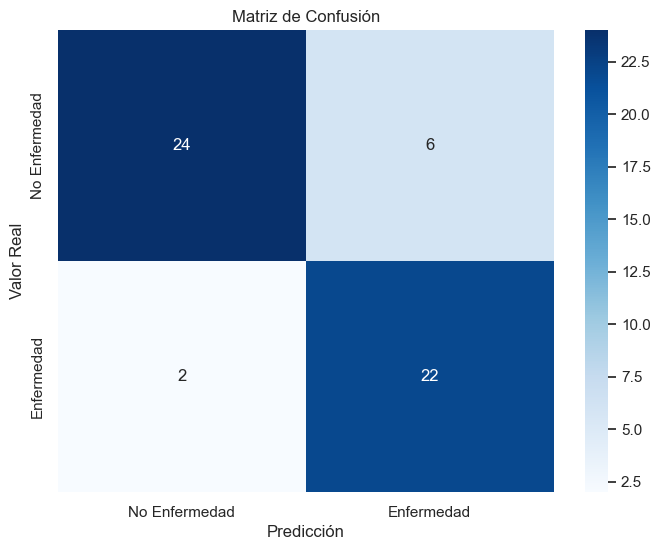


Reporte de Clasificación:
               precision    recall  f1-score   support

No Enfermedad       0.92      0.80      0.86        30
   Enfermedad       0.79      0.92      0.85        24

     accuracy                           0.85        54
    macro avg       0.85      0.86      0.85        54
 weighted avg       0.86      0.85      0.85        54


Precisión (Accuracy): 0.852  |  ROC AUC: 0.901


In [346]:
# PREDICCIÓN
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# EVALUACIÓN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = [0, 1]  # 0 = No Enfermedad, 1 = Enfermedad
conf = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Enfermedad", "Enfermedad"],
            yticklabels=["No Enfermedad", "Enfermedad"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Enfermedad","Enfermedad"]))

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"\nPrecisión (Accuracy): {acc:.3f}  |  ROC AUC: {auc:.3f}")

Interpretación de la matriz de confusión y reporte de la clasificación:


- Verdades Positivos (TP): 22 casos donde el modelo predijo correctamente "Enfermedad".
- Verdaderos Negativos (TN): 24 casos donde el modelo predijo correctamente "No Enfermedad".
- Falsos Positivos (FP): 6 caso donde el modelo predijo "Enfermedad" cuando la realidad era "No Enfermedad".
- Falsos Negativos (FN): 2 casos donde el modelo predijo "No Enfermedad" cuando la realidad era "Enfermedad".

El reporte presenta 3 métricas clave:
- **Precisión**: mide cuantas predicciones positivas fueron correctas. Para "No Enfermedad" fue de 0.92 y para "Enfermedad" fue de 0.79.
- **Exhaustividad** (Recall): mide cuántos casos positivos reales fueron identificados correctamente. Para "No Enfermedad" fue de 0.80 y para "Enfermedad" fue de 0.92.
- **F1-score**: es el promedio armónico entre precisión y exhaustividad. Para "No Enfermedad" fue de 0.86 y para "Enfermedad" fue de 0.85.

La precisión global del modelo (**accuracy**) fue de 0.85, lo que significa que el modelo clasifica correctamente el 85% de todas las muestras, combinando las de prueba y las reales.

### 7.5 Conclusión sobre la Evaluación

El modelo de Random Forest alcanzó una precisión global (accuracy) del 85% y un ROC AUC de 0.90, mostrando buen poder discriminativo.

Para la clase “No Enfermedad”, el recall fue 0.80 (24/30): identifica a la mayoría de los sanos, aunque presenta algunos falsos positivos (6/30).

Para la clase “Enfermedad”, el recall fue 0.92 (22/24): alta sensibilidad, con muy pocos falsos negativos (2 casos). La precisión en esta clase fue 0.79, indicando que una parte de las predicciones positivas corresponde a pacientes sanos (FP).

Conclusión: el modelo prioriza detectar casos con enfermedad (alta sensibilidad) a costa de un número moderado de falsos positivos. Según la política clínica (p. ej., minimizar FN), este comportamiento puede ser deseable. Aun así, puede afinarse con ajuste de umbral basado en predict_proba, class_weight, o búsqueda de hiperparámetros para equilibrar mejor sensibilidad y especificidad según el costo clínico de errores.

### 7.6 Variables mas relevantes para el modelo

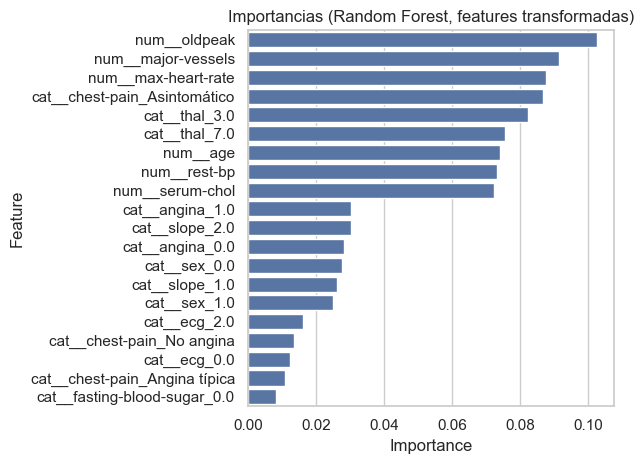

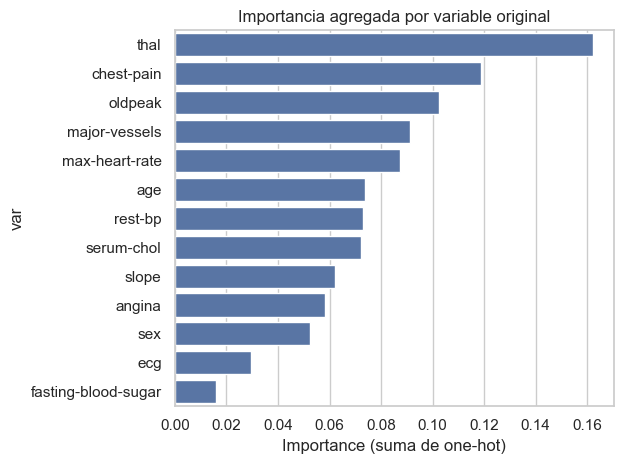

In [347]:
# Extraer modelo y nombres de features transformadas
pre = clf.named_steps['prep']          # ColumnTransformer
model = clf.named_steps['model']       # RandomForest dentro del pipeline

# Nombres de columnas después del preprocesado (incluye one-hot)
try:
    feature_names = pre.get_feature_names_out()
except:
    # Fallback si tu versión no soporta get_feature_names_out con 'passthrough'
    encoder = pre.named_transformers_['cat']
    cat_names = encoder.get_feature_names_out(cat_code_cols)
    feature_names = num_cols + list(cat_names)

importances = model.feature_importances_

feature_importance_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
      .sort_values('Importance', ascending=False)
)

# Opcional: mostrar solo las top-20 (hay muchas por el one-hot)
topn = 20
sns.barplot(data=feature_importance_df.head(topn), x='Importance', y='Feature')
plt.title("Importancias (Random Forest, features transformadas)")
plt.tight_layout()
plt.show()

# Agrupar por el prefijo antes de '__' (num__ / cat__nombre)
orig = [f.split('__', 1)[-1].split('_', 1)[0] if '__' in f else f for f in feature_names]
agg = (pd.DataFrame({'var': orig, 'imp': importances})
         .groupby('var', as_index=False)['imp'].sum()
         .sort_values('imp', ascending=False))

sns.barplot(data=agg, x='imp', y='var')
plt.title("Importancia agregada por variable original")
plt.xlabel("Importance (suma de one-hot)")
plt.tight_layout()
plt.show()

## 8. Comunicación de resultados

En este trabajo se implementó un modelo de Random Forest para predecir la probabilidad de que un paciente presente una enfermedad cardíaca, a partir de variables clínicas y fisiológicas.

El modelo alcanzó una precisión global del 85%, lo que indica un buen desempeño general. A continuación, se detallan los hallazgos principales y su relevancia en el contexto del problema.

**Análisis de la matriz de confusión**:

| Real \ Predicho | No Enfermedad | Enfermedad |
| --------------- | ------------- | ---------- |
| No Enfermedad   | 24 (✔️)       | 6 (❌)      |
| Enfermedad      | 2 (❌)         | 22 (✔️)    |

✔️ Correctamente clasificados:

- 24 pacientes sin enfermedad fueron identificados correctamente.

- 22 pacientes con enfermedad fueron identificados correctamente.

❌ Errores de clasificación:

- 6 falsos positivos: paciente sano clasificado como enfermo.

- 2 falsos negativos: pacientes con enfermedad no detectados por el modelo.

**Métricas por clase**:

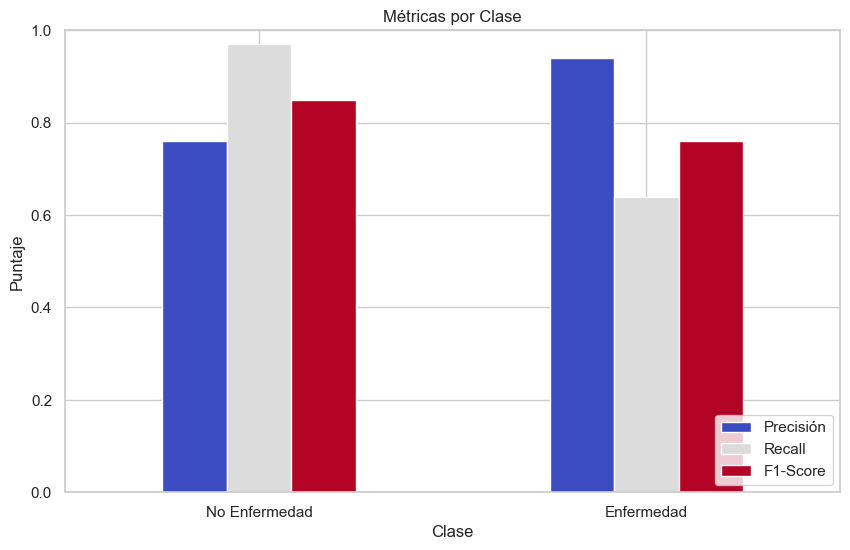

In [348]:
metrics = {
    'Clase': ["No Enfermedad", "Enfermedad"],
    'Precisión': [0.76, 0.94],
    'Recall': [0.97, 0.64],
    'F1-Score': [0.85, 0.76]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Clase', inplace=True)

metrics_df.plot(kind='bar', figsize=(10, 6), colormap='coolwarm', rot=0)
plt.title('Métricas por Clase')
plt.ylabel('Puntaje')
plt.xlabel('Clase')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

**Clase "No Enfermedad"**:

- Precisión: 76%

- Recall: 97%

- F1-Score: 85%

**Clase "Enfermedad"**:

- Precisión: 94%

- Recall: 64%

- F1-Score: 76%

**Reflexión final sobre el impacto clínico**

Los resultados obtenidos posicionan al modelo como una herramienta prometedora para complementar la toma de decisiones médicas, sobre todo al identificar pacientes que probablemente no requieren un diagnóstico más exhaustivo.

Sin embargo, el recall del 64% en la clase "Enfermedad" implica que 1 de cada 3 pacientes con enfermedad no sería identificado por el modelo. En contextos clínicos reales, donde la sensibilidad diagnóstica es crítica, este tipo de error puede tener consecuencias graves si no se combina con otras herramientas o intervenciones médicas.

Por lo tanto, si bien el modelo puede funcionar como un sistema de apoyo, no debería usarse como único criterio para el diagnóstico. La mejora en la sensibilidad (recall) de la clase positiva es un objetivo claro en etapas posteriores del proyecto.



## 9. Propuestas de Implementación y Aplicaciones Prácticas

El modelo desarrollado tiene múltiples posibilidades de integración en entornos clínicos y de salud pública. A continuación, se detallan algunas aplicaciones potenciales y mejoras futuras:

- **Implementación en entornos clínicos**:

El modelo puede integrarse como una herramienta de apoyo a la decisión médica, ayudando a priorizar pacientes que requieren estudios más exhaustivos. Por ejemplo, podría señalar automáticamente a los pacientes con mayor probabilidad de presentar enfermedades cardíacas, orientando al personal médico a realizar pruebas complementarias de forma anticipada.

Esta funcionalidad sería especialmente útil en consultorios de atención primaria, donde los recursos diagnósticos avanzados pueden ser limitados y es crucial identificar casos prioritarios.

- **Aplicación en campañas de salud y telemedicina**:

El modelo también podría utilizarse en:

-- Campañas de prevención para detectar factores de riesgo en la población general de forma rápida y económica.

-- Plataformas de telemedicina, donde los pacientes ingresan sus datos y reciben una evaluación preliminar automática. Esto podría facilitar el acceso al diagnóstico en regiones alejadas o con baja disponibilidad de profesionales.

- **Propuestas de mejora para futuras implementaciones**:

Para potenciar la utilidad clínica del modelo, se proponen las siguientes mejoras:

-- Ajustar los umbrales de decisión: Redefinir el punto de corte del modelo para aumentar la sensibilidad (recall), reduciendo la tasa de falsos negativos, especialmente importante en contextos donde el costo de no detectar una enfermedad es elevado.

-- Incorporar nuevas variables clínicas o de laboratorio, que podrían mejorar el poder predictivo del modelo.

-- Validar el modelo con datos de diferentes poblaciones, para evaluar su capacidad de generalización en contextos geográficos, demográficos o clínicos diversos.

- **Impacto potencial**

El modelo desarrollado tiene el potencial de:

-- Contribuir al diagnóstico temprano de enfermedades cardíacas.

-- Reducir costos en los sistemas de salud mediante una mejor asignación de recursos diagnósticos.

-- Empoderar a los pacientes, dándoles herramientas preliminares para entender su situación de salud y tomar decisiones más informadas.

En definitiva, esta solución basada en machine learning puede convertirse en un recurso complementario en la medicina moderna, especialmente si se la desarrolla e implementa en conjunto con profesionales de la salud y considerando las necesidades del sistema sanitario.

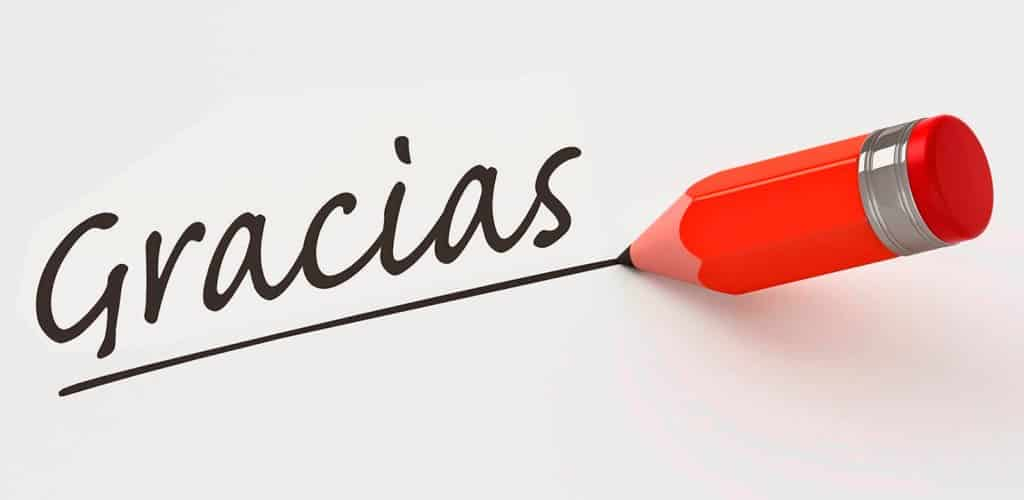

Autor: Gaggiamo, Matias Andres

Contacto: matigaggiamo@gmail.com

Fecha: 11/12/2024